In [1]:
import pandas as pd 
import os
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import shap 
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


from sklearn.preprocessing import LabelEncoder

# Pretreat data - data is loaded as csv files from individual class measurements 

os.chdir('C:/Users/lsest/OneDrive - Danmarks Tekniske Universitet/Experiments/V26 Online image analysis/Datasets/Ocelloscope/500_trainingset/Measurements')

df_gf = pd.read_csv('Measurements_Greenflag.csv') 
df_gr = pd.read_csv('Measurements_Greenround.csv')
df_rf = pd.read_csv('Measurements_Redflag.csv')
df_rr = pd.read_csv('Measurements_Redround.csv')
df_ot = pd.read_csv('Measurements_Others.csv')

# Add labels to each dataframe 

df_gf['Label']= 'Greenflag'
df_gr['Label']= 'Greenround'
df_rf['Label']= 'Redflag'
df_rr['Label']= 'Redround'
df_ot['Label']= 'Others'





Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Combine to one data set and order them randomly to prevent order bias

df = pd.concat([df_gf,df_gr,df_rf,df_rr,df_ot])


In [3]:
#df.drop(['%Area'], axis=1, inplace=True) # %Area gives 0 in all rows

df.head()

,,Area,Mean,StdDev,Mode,Min,Max,X,Y,XM,...,%Area,RawIntDen,FeretX,FeretY,FeretAngle,MinFeret,AR,Round,Solidity,Label
0,1,1208,89.021,26.146,64,43,155,20.246,20.217,19.959,...,0,107537.0,1,13,160.253,38.460,1.054,0.949,0.954,Greenflag
1,2,2040,75.408,36.708,54,29,186,24.543,28.947,26.280,...,0,153833.0,13,56,73.113,48.333,1.188,0.842,0.950,Greenflag
2,3,718,57.696,30.563,29,20,168,19.852,9.311,17.907,...,0,41426.0,0,8,11.041,22.000,1.821,0.549,0.966,Greenflag
3,4,834,107.619,29.046,99,53,184,18.271,12.653,17.926,...,0,89754.0,0,3,156.801,29.000,1.229,0.814,0.964,Greenflag
4,5,625,58.037,24.529,54,22,162,13.196,15.769,13.978,...,0,36273.0,11,0,95.528,26.835,1.135,0.881,0.938,Greenflag


In [4]:

rand_df = df.sample(frac=1).reset_index(drop = True) #Shuffle rows to prevent bias

#Format data to have one dataset of what we want to predict and one of what should be used to predict 
X = rand_df.drop('Label', axis =1).copy()


In [5]:
y = rand_df['Label'].copy()

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)



{'Greenflag': 0, 'Greenround': 1, 'Others': 2, 'Redflag': 3, 'Redround': 4}


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, stratify = y) # Splits dataset in training and validation 
#stratify helps to make sure that equal amounts of each label are used.
#Actually this function also shuffles the dataset so the randomisation earlier was maybe not necessary

## Run XGBoost

In [7]:
clf_xgb = xgb.XGBClassifier(objective = 'multi:softmax',
                            early_stopping_rounds = 20, 
                            eval_metric ='mlogloss') 
clf_xgb.fit(X_train,
            y_train,
            verbose = True,
            eval_set=[(X_test, y_test)])
clf_xgb.save_model('V26_Classifiermodel.json')

[0]	validation_0-mlogloss:1.11138
[1]	validation_0-mlogloss:0.86333
[2]	validation_0-mlogloss:0.69933
[3]	validation_0-mlogloss:0.58971
[4]	validation_0-mlogloss:0.51101
[5]	validation_0-mlogloss:0.45268
[6]	validation_0-mlogloss:0.40657
[7]	validation_0-mlogloss:0.37671
[8]	validation_0-mlogloss:0.35140
[9]	validation_0-mlogloss:0.33245
[10]	validation_0-mlogloss:0.31661
[11]	validation_0-mlogloss:0.30141
[12]	validation_0-mlogloss:0.28685
[13]	validation_0-mlogloss:0.27816
[14]	validation_0-mlogloss:0.27072
[15]	validation_0-mlogloss:0.26884
[16]	validation_0-mlogloss:0.26243
[17]	validation_0-mlogloss:0.26260
[18]	validation_0-mlogloss:0.25841
[19]	validation_0-mlogloss:0.25603
[20]	validation_0-mlogloss:0.25387
[21]	validation_0-mlogloss:0.25330
[22]	validation_0-mlogloss:0.25315
[23]	validation_0-mlogloss:0.25165
[24]	validation_0-mlogloss:0.25088
[25]	validation_0-mlogloss:0.25027
[26]	validation_0-mlogloss:0.25016
[27]	validation_0-mlogloss:0.25104
[28]	validation_0-mlogloss:0.2

In [ ]:
 ## Check parameters before:  

 #Round 1
 param_grid = {
     'max_depth': [3,4,5],
     'learning_rate':[0.1,0.5,1],
     'gamma': [0,0.05,0.1],
     'reg_lambda':[0,1.0,10.0],
 }
 ##Output: Best Parameters: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 0, 'scale_pos_weight': 1}

 #Round 2
 param_grid = {
    'max_depth': [4],
    'learning_rate':[0.13,0.14,0.15],
    'gamma': [0.12],
    'reg_lambda':[0.01],
 }
 ##Output: Best Parameters: {'gamma': 0.12, 'learning_rate': 0.13, 'max_depth': 4, 'reg_lambda': 0.01}


 optimal_params=GridSearchCV(estimator=xgb.XGBClassifier(objective='multi:softmax',
                                                         num_class=5,
                                                         ),
                                                         param_grid = param_grid,
                                                         scoring='roc_auc_ovr', 
                                                         verbose=0, 
                                                         n_jobs=10,
                                                         cv=3
 )

In [ ]:
 #Optimise parameters 
 optimal_params.fit(X_train,
                    y_train,
                    eval_set=[(X_test, y_test)],
                    verbose = False)
 print("Best Parameters:", optimal_params.best_params_)

## Build XGBoost model again with optimised parameters

In [ ]:
clf_xgb = xgb.XGBClassifier(objective = 'multi:softmax',
                          gamma=0.12,
                          learning_rate=0.13,
                          max_depth=4,
                            reg_lambda=0.01,
                            early_stopping_rounds = 30, 
                            eval_metric =['mlogloss','merror'],
                            
                            num_class =5
                           ) 
clf_xgb.fit(X_train,
            y_train,
            verbose = True,
            eval_set=[(X_test, y_test)])

In [9]:
# Get Overview of Hyperparameters
params = clf_xgb.get_params()
print("Learning rate:", params.get('learning_rate'))
print("Max depth:", params.get('max_depth'))
print("Gamma:", params.get('gamma'))  # Added line for gamma
print("Reg lambda:", params.get('reg_lambda'))

# Check if the model has 'best_iteration' attribute, indicating use of early stopping
if hasattr(clf_xgb, 'best_iteration'):
    num_trees = clf_xgb.best_iteration + 1
    print(f"The model contains {num_trees} trees.")

# Assuming you have saved the training accuracy during model training
# If you have the evaluation set results stored, you can retrieve the last recorded training accuracy
# This assumes clf_xgb.evals_result() contains the training evaluation results and that 'accuracy' was a monitored metric
if hasattr(clf_xgb, 'evals_result'):
    evals_result = clf_xgb.evals_result()
    # Assuming 'merror' was used and you want to convert it to accuracy
    if 'merror' in evals_result['validation_0']:
        last_error_rate = evals_result['validation_0']['merror'][-1]
        training_accuracy = 1 - last_error_rate
        print(f"Training accuracy: {training_accuracy:.4f}")


Learning rate: None
Max depth: None
Gamma: None
Reg lambda: None
The model contains 23 trees.


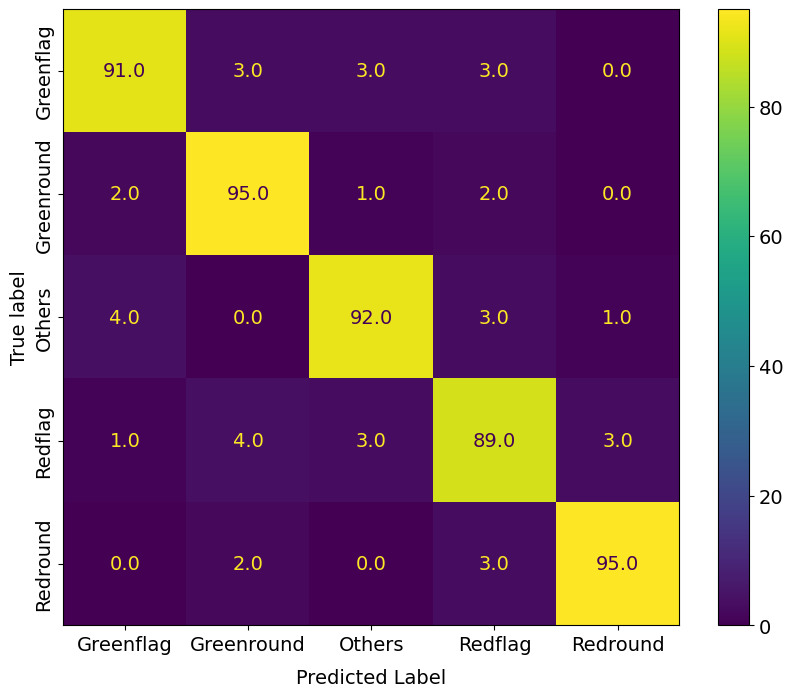

In [17]:
# Assuming clf_xgb is your trained XGBoost model and X_test, y_test are defined
# Generate predictions
predictions = clf_xgb.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Set global font size for all text elements
plt.rcParams.update({'font.size': 14})

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Greenflag', 'Greenround', 'Others', 'Redflag', 'Redround'])
fig, ax = plt.subplots(figsize=(10, 8))  # Optional: adjust figure size
disp.plot(values_format='.1f', cmap='viridis', ax=ax)

# Rotate y-axis tick labels
ax.set_yticklabels(['Greenflag', 'Greenround', 'Others', 'Redflag', 'Redround'], rotation=90, verticalalignment='center')

# Optionally adjust the position and orientation of the x-axis label as well
ax.set_xlabel('Predicted Label', labelpad=10)

# Display the plot
#plt.show()

# Save the plot to a file
plt.savefig('Tmodel_confusion_matrix.png', bbox_inches='tight')


## Make a Tree (for illustration)

In [ ]:
clf_xgb = xgb.XGBClassifier(objective = 'multi:softmax',
                           gamma=0,
                           learning_rate=0.1,
                           max_depth=4,
                           reg_lambda=10,
                           n_estimators=1) 
clf_xgb.fit(X_train,
            y_train)

bst = clf_xgb.get_booster()
for importance_type in ('weight','gain','cover','total_gain','total_cover'): 
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

node_params={'shape':'box',
             'style':'filled, rounded',
             'fillcolor':'#78cbe'}
leaf_params={'shape':'box', 
             'style':'filled', 
             'fillcolor':'#ab2c2c'}

graph_data = xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
                condition_node_params=node_params,
                leaf_node_params=leaf_params)

graph_data.view(filename='xgboost_tree_500_imageanalysis') 

## Check influence of parameters

In [ ]:
ax = xgb.plot_importance(clf_xgb, max_num_features=34, importance_type='weight')
plt.show()

# Save the plot to a file
ax.figure.savefig('importance.png',bbox_inches='tight')  



importance = clf_xgb.get_booster().get_score(importance_type='gain')
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_importance: 
    print(f"Feature: {feature}, Importance: {importance}")
  

## SHAP analysis

In [10]:
# Ensure X_test is a DataFrame with the correct number of feature columns
#feature_names = ['Area','Mean','StdDev','Mode','Min','Max','X','Y','XM','YM','Perim.','BX','BY','Width','Height','Major','Minor','Angle','Circ.','Feret','IntDen','Median','Skew','Kurt','%Area','RawIntDen','FeretX','FeretY','FeretAngle','MinFeret','AR','Round','Solidity']  # Replace with actual feature names


# Explain predictions with SHAP values 
explainer = shap.TreeExplainer(clf_xgb, feature_perturbation='interventional') 
shap_values = explainer(X_test, check_additivity=False) 

num_classes = 5

#Array with correct predictions 
a = ([0,8,1,3,2])

#Array with class names
names=(['Greenflag','Greenround','Others','Redflag','Redround'])

# Get model's prediction for the class
for j in range(len(a)):
    for i in  range(num_classes): 
        model_prediction = clf_xgb.predict_proba(X_test)[a[j],i]
        plt.figure()
        shap.plots.waterfall(shap_values[a[j],:,i], show = False, max_display = 10)
        plt.title(f"Class: {names[i]} - Model Prediction: {model_prediction:.2f}")
        plt.savefig(f"Waterfall {i,j}.png",bbox_inches='tight')
        plt.close()
        


    

